source integral =  35.4490766453062
source integral =  0.9999999619321295


/home/wenzheng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide
/home/wenzheng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


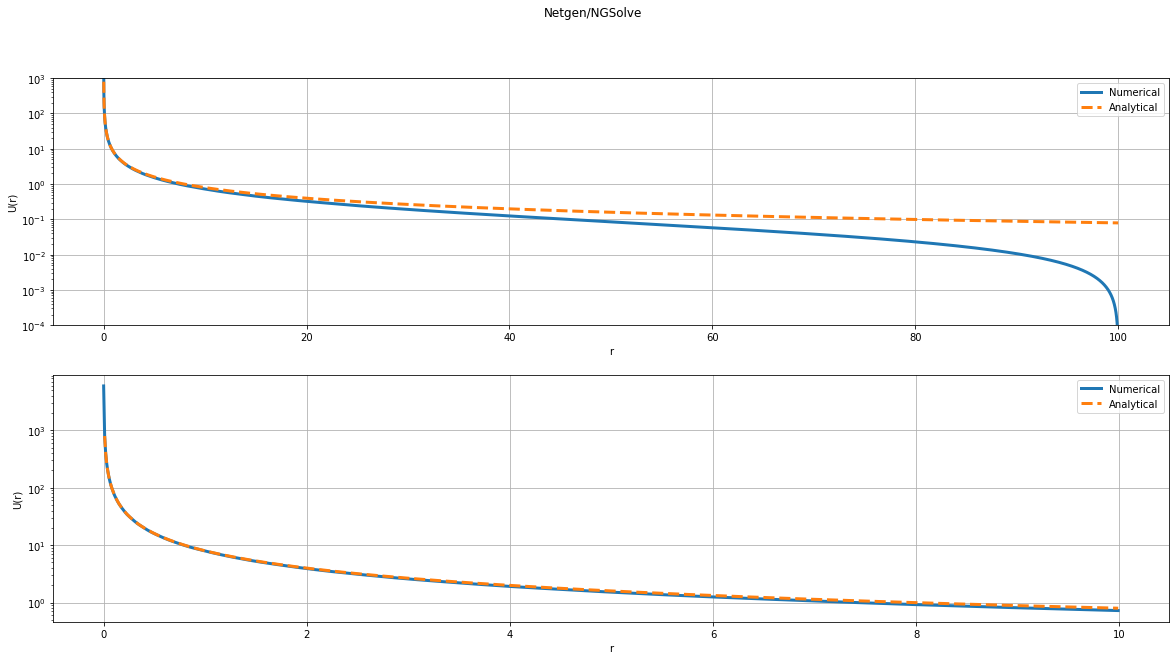

In [11]:
from ngsolve import *
from netgen.geom2d import SplineGeometry

import numpy as np
import math

def MakeGeometry(d_r, d_z, maxh):
    geometry = SplineGeometry()

    # point coordinates
    points = [ (0, 0), (0, 0.1), (0, d_z), (d_r, d_z), (d_r, -d_z), (0, -d_z), (0, -0.1)]
    pnums = [geometry.AppendPoint(*p) for p in points]

    # start-point, end-point, boundary-condition, domain on left side, domain on right side, maxh:
    lines = [ (0,1,1,0,1,0.01), (1,2,1,0,1,maxh), (2,3,2,0,1,maxh), (3,4,2,0,1,maxh), (4,5,2,0,1,maxh), (5,6,1,0,1,maxh), (6,0,1,0,1,0.01)]

    for p1,p2,bc,left,right, mesh_size in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right, maxh=mesh_size)
    return geometry



def AddPointSource (f, x, y, fac):
    spc = f.space
    mp = spc.mesh(x,y)
    ei = ElementId(VOL, mp.nr)
    fel = spc.GetFE(ei)
    dnums = spc.GetDofNrs(ei)
    shape = fel.CalcShape(*mp.pnt)
    for d,s in zip(dnums, shape):
        f.vec[d] += fac*s


# Parameters
I = 1 #electric current
rho = 100 #resistivity
d_r = 100 #radius of domain
d_z = 100 # 1/2 of hight of domain
maxh = 10 # mesh size
alpha = 1/20 # parameter in Dirac's delta aproximation

sigma = CoefficientFunction([1/rho]) #conductivity
# dd = CoefficientFunction(1/(abs(alpha)*math.sqrt(np.pi))*exp(-((x**2 + y**2)**(1/2)/alpha)**2)) # Dirac's delta
dd = CoefficientFunction(2/(abs(alpha)**3*math.sqrt(np.pi))*exp(-(x**2 + y**2)/alpha**2)) # Dirac's delta

model_geometry = MakeGeometry(d_r, d_z, maxh)
mesh = Mesh(model_geometry.GenerateMesh(maxh=maxh))

print ("source integral = ", Integrate (dd, mesh))
print ("source integral = ", Integrate (x*dd, mesh)) # approximates 1 
Draw (dd, mesh, "source")

fes = H1(mesh, order=2, dirichlet=[2])
u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm(fes, symmetric=False)
a += 2*np.pi*grad(u)*grad(v)*x*sigma*dx

f = LinearForm(fes)
# f += x*dd*I*v*dx
f.Assemble()
AddPointSource (f, 0,0, I)


a.Assemble()

gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f.vec

Draw (gfu)

#Comparison of numerical and analytical solution
import matplotlib.pyplot as plt

x_long = [0.01*i for i in range(d_r*100)]
x_short = [0.01*i for i in range(d_r*10)]

u_numerical_long = [gfu(mesh(p, 0.0)) for p in x_long]
u_numerical_short = [gfu(mesh(p, 0.0)) for p in x_short]

fig, axs = plt.subplots(2, figsize=(20, 10))
fig.suptitle('Netgen/NGSolve')
axs[0].plot(x_long, u_numerical_long, linewidth=3, label='Numerical')
axs[0].plot(x_long, I/(1/rho*4*np.pi*np.array(x_long)), linewidth=3, linestyle='--', label='Analytical')
axs[0].set_yscale('log')
axs[0].set_ylim(0.0001, 1000)
axs[0].grid()
axs[0].legend(loc=0)
axs[0].set_xlabel("r")
axs[0].set_ylabel("U(r)")

axs[1].plot(x_short, u_numerical_short, linewidth=3, label='Numerical')
axs[1].plot(x_short, I/(1/rho*4*np.pi*np.array(x_short)), linewidth=3, linestyle='--', label='Analytical')
axs[1].set_yscale('log')
axs[0].set_ylim(0.0001, 1000)
axs[1].grid()
axs[1].legend(loc=0)
axs[1].set_xlabel("r")
axs[1].set_ylabel("U(r)")
plt.show()